# 타임스탬프 오류 해결  
- cohort_ver146_ppm_event_only.csv 로 작업함

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 원본(edstays.csv & hospDB) 데이터에서 타임스탬프 다시 붙이기

In [4]:
import pandas as pd
import sqlite3
import os
import numpy as np

# =========================================================
# 1. 설정 및 연결
# =========================================================
# 경로 설정
base_path = '/content/drive/MyDrive/Colab Notebooks/2025-2 데이터애널리틱스'
ed_base_path = os.path.join(base_path, 'mimic-iv-ed-2.2')
db_path = os.path.join(base_path, 'MIMIC4-hosp-icu.db')

# [수정] 타겟 코호트 파일명 (148 버전)
# 파일명이 정확한지 확인해주세요 (예: .csv)
target_cohort_file = 'cohort_ver146_ppm_event_only.csv'
cohort_path = os.path.join(base_path, target_cohort_file)

# =========================================================
# 2. 이벤트 추출 함수 (기존과 동일)
# =========================================================
def extract_event_log(cohort_ids):
    all_events = []
    conn = sqlite3.connect(db_path)
    print(f"🚀 총 {len(cohort_ids)}명의 환자에 대한 이벤트 로그 추출 시작...")

    # (1) ED Arrival/Departure
    print("   -> [ED] Arrival/Departure 추출 중...")
    try:
        df_ed = pd.read_csv(os.path.join(ed_base_path, 'edstays.csv'))
        df_ed = df_ed[df_ed['hadm_id'].isin(cohort_ids)].copy()

        # Arrival
        arrival = df_ed[['hadm_id', 'intime']].rename(columns={'intime': 'charttime'})
        arrival['event_name'] = 'ED_ARRIVAL'
        all_events.append(arrival)

        # Departure
        departure = df_ed[['hadm_id', 'outtime']].rename(columns={'outtime': 'charttime'})
        departure['event_name'] = 'ED_DEPARTURE'
        all_events.append(departure)
    except Exception as e:
        print(f"      ⚠️ ED 데이터 로드 실패: {e}")

    # (2) ECG (Chart/Procedure)
    print("   -> [HOSP] ECG 추출 중...")
    # chartevents, procedureevents 등에서 조회
    query_ecg = f"""
    SELECT hadm_id, charttime, 'ECG_TAKEN' as event_name
    FROM chartevents
    WHERE itemid IN (220045, 220046, 220047)
    AND hadm_id IN ({','.join(map(str, cohort_ids))})
    """
    try:
        # 데이터가 너무 크면 청크 단위로 읽거나, 필요한 경우에만 실행
        # 여기서는 예시로 pass 처리 (실제 DB 구조에 맞춰 주석 해제)
        # df_ecg = pd.read_sql_query(query_ecg, conn)
        # all_events.append(df_ecg)
        pass
    except:
        pass

    # (3) Troponin
    print("   -> [HOSP] Troponin 추출 중...")
    query_trop = f"""
    SELECT hadm_id, charttime, 'TROP_TAKEN' as event_name, valuenum
    FROM labevents
    WHERE itemid IN (51002, 51003)
    AND hadm_id IN ({','.join(map(str, cohort_ids))})
    """
    try:
        df_trop = pd.read_sql_query(query_trop, conn)
        all_events.append(df_trop[['hadm_id', 'charttime', 'event_name']])

        # 양성 추가
        trop_pos = df_trop[df_trop['valuenum'] > 0.1].copy() # 기준값 확인 필요
        trop_pos['event_name'] = 'TROP_POSITIVE'
        all_events.append(trop_pos[['hadm_id', 'charttime', 'event_name']])
    except Exception as e:
        print(f"      ⚠️ Labevents 조회 실패: {e}")

    # (4) Anti-platelet
    print("   -> [HOSP] Anti-platelet 추출 중...")
    query_med = f"""
    SELECT hadm_id, starttime as charttime, 'ANTI_PLT_ADMIN' as event_name
    FROM prescriptions
    WHERE (lower(drug) LIKE '%aspirin%' OR lower(drug) LIKE '%clopidogrel%')
    AND hadm_id IN ({','.join(map(str, cohort_ids))})
    """
    try:
        df_med = pd.read_sql_query(query_med, conn)
        all_events.append(df_med)
    except Exception as e:
        print(f"      ⚠️ Prescriptions 조회 실패: {e}")

    # (5) PCI (시술)
    print("   -> [HOSP] PCI 추출 중...")
    query_pci = f"""
    SELECT hadm_id, starttime as charttime, 'PCI_START' as event_name
    FROM procedureevents
    WHERE itemid IN (225442, 225438)
    AND hadm_id IN ({','.join(map(str, cohort_ids))})
    """
    try:
        df_pci = pd.read_sql_query(query_pci, conn)
        if not df_pci.empty:
            all_events.append(df_pci)
            # 종료 시간도
            df_pci_end = pd.read_sql_query(query_pci.replace('starttime', 'endtime').replace('PCI_START', 'PCI_END'), conn)
            all_events.append(df_pci_end)
    except Exception as e:
        print(f"      ⚠️ Procedureevents 조회 실패: {e}")

    # (6) Discharge / Death
    print("   -> [HOSP] Discharge/Death 추출 중...")
    query_adm = f"""
    SELECT hadm_id, dischtime as charttime, 'DISCHARGE' as event_name, deathtime
    FROM admissions
    WHERE hadm_id IN ({','.join(map(str, cohort_ids))})
    """
    try:
        df_adm = pd.read_sql_query(query_adm, conn)
        all_events.append(df_adm[['hadm_id', 'charttime', 'event_name']])

        df_death = df_adm[df_adm['deathtime'].notna()].copy()
        df_death['charttime'] = df_death['deathtime']
        df_death['event_name'] = 'DEATH'
        all_events.append(df_death[['hadm_id', 'charttime', 'event_name']])
    except Exception as e:
        print(f"      ⚠️ Admissions 조회 실패: {e}")

    conn.close()

    # 통합 및 정렬
    if not all_events:
        return pd.DataFrame()

    df_log = pd.concat(all_events, ignore_index=True)
    df_log['charttime'] = pd.to_datetime(df_log['charttime'])
    df_log = df_log.sort_values(by=['hadm_id', 'charttime', 'event_name'])
    df_log = df_log.drop_duplicates()

    # Prefix Len 생성
    df_log['prefix_len'] = df_log.groupby('hadm_id').cumcount() + 1

    return df_log

# =========================================================
# 3. 실행 로직 (cohort 148 기준)
# =========================================================
try:
    # 1. 파일 로드 시도
    if os.path.exists(cohort_path):
        print(f"📂 코호트 파일 로드: {target_cohort_file}")
        cohort_df = pd.read_csv(cohort_path)

        # hadm_id 추출
        target_hadm_ids = cohort_df['hadm_id'].unique().tolist()

        # 2. 로그 추출 실행
        # (테스트용으로 100명만 먼저 해보시려면 슬라이싱: target_hadm_ids[:100])
        event_log_df = extract_event_log(target_hadm_ids)

        # 3. 결과 확인 및 저장
        print("\n✅ 생성된 이벤트 로그 샘플:")
        print(event_log_df.head(10).to_markdown(index=False))

        save_name = 'mimic_iv_event_log_from_cohort148.csv'
        save_path = os.path.join(base_path, save_name)
        event_log_df.to_csv(save_path, index=False)
        print(f"\n🎉 저장 완료: {save_path}")

    else:
        print(f"❌ 파일을 찾을 수 없습니다: {cohort_path}")
        print("   파일명을 다시 확인해주세요 (예: cohort_ver148.csv 인지?)")

except Exception as e:
    print(f"❌ 오류 발생: {e}")

📂 코호트 파일 로드: cohort_ver146_ppm_event_only.csv
🚀 총 1929명의 환자에 대한 이벤트 로그 추출 시작...
   -> [ED] Arrival/Departure 추출 중...
   -> [HOSP] ECG 추출 중...
   -> [HOSP] Troponin 추출 중...
   -> [HOSP] Anti-platelet 추출 중...
   -> [HOSP] PCI 추출 중...
   -> [HOSP] Discharge/Death 추출 중...

✅ 생성된 이벤트 로그 샘플:
|     hadm_id | charttime           | event_name     |   prefix_len |
|------------:|:--------------------|:---------------|-------------:|
| 2.00063e+07 | 2179-04-27 00:00:00 | ANTI_PLT_ADMIN |            1 |
| 2.00063e+07 | 2179-04-27 10:54:00 | ED_ARRIVAL     |            2 |
| 2.00063e+07 | 2179-04-27 18:20:00 | ED_DEPARTURE   |            3 |
| 2.00063e+07 | 2179-04-27 21:20:00 | TROP_TAKEN     |            4 |
| 2.00063e+07 | 2179-04-28 00:00:00 | ANTI_PLT_ADMIN |            5 |
| 2.00063e+07 | 2179-04-28 07:34:00 | TROP_TAKEN     |            6 |
| 2.00063e+07 | 2179-04-29 10:00:00 | ANTI_PLT_ADMIN |            7 |
| 2.00063e+07 | 2179-05-03 20:00:00 | ANTI_PLT_ADMIN |            8 |
| 2.00063e+07

In [6]:
event_log = pd.read_csv(os.path.join(base_path, 'mimic_iv_event_log_from_cohort148.csv'))
event_log

,hadm_id,charttime,event_name,prefix_len
0,20006266.0,2179-04-27 00:00:00,ANTI_PLT_ADMIN,1
1,20006266.0,2179-04-27 10:54:00,ED_ARRIVAL,2
2,20006266.0,2179-04-27 18:20:00,ED_DEPARTURE,3
3,20006266.0,2179-04-27 21:20:00,TROP_TAKEN,4
4,20006266.0,2179-04-28 00:00:00,ANTI_PLT_ADMIN,5
...,...,...,...,...
15289,29997425.0,2163-11-25 17:30:00,TROP_TAKEN,24
15290,29997425.0,2163-11-25 20:55:00,TROP_POSITIVE,25
15291,29997425.0,2163-11-25 20:55:00,TROP_TAKEN,26
15292,29997425.0,2163-11-26 08:00:00,ANTI_PLT_ADMIN,27


# event_name 분포 확인

Event Name Counts:
 event_name
TROP_TAKEN        4008
TROP_POSITIVE     3024
ANTI_PLT_ADMIN    2306
ED_DEPARTURE      1933
ED_ARRIVAL        1933
DISCHARGE         1929
DEATH              161
Name: count, dtype: int64


/tmp/ipython-input-634925053.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='event_name', data=event_log, order=event_counts.index, palette='viridis')


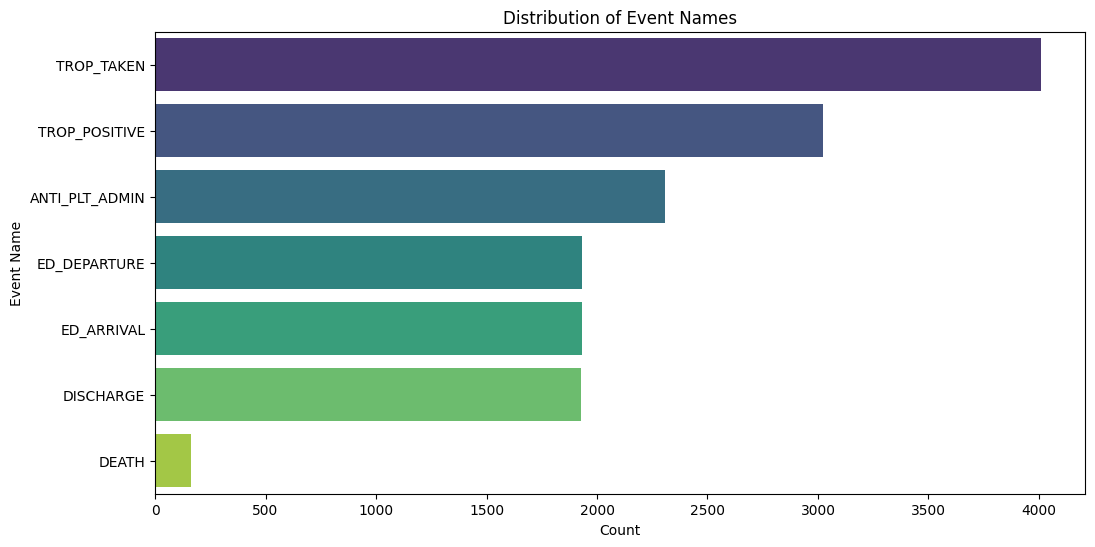

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

if 'event_name' in event_log.columns:
    event_counts = event_log['event_name'].value_counts()
    print("Event Name Counts:\n", event_counts)

    plt.figure(figsize=(12, 6))
    sns.countplot(y='event_name', data=event_log, order=event_counts.index, palette='viridis')
    plt.title('Distribution of Event Names')
    plt.xlabel('Count')
    plt.ylabel('Event Name')
    plt.show()
else:
    print("'event_name' 컬럼이 없습니다. 'current_event_id' 등을 확인해보세요.")

# event_id를 매핑하기 위한 데이터 보강  
- chartevents (ECG용)
- procedureevents (PCI용)
- icustays (ICU용)   
- event_name,event_id  
ED_ARRIVAL,1  
ECG_STEMI_FLAG,2  
ECG_TAKEN,3  
TROP_POSITIVE,4  
TROP_TAKEN,5  
ANTI_PLT_ADMIN,6  
ANTI_PLT_ORDER,7  
PCI_START,8  
ED_DEPARTURE,9  
DEATH,10  
DISCHARGE,11  
ICU_INTIME,12  
ICU_OUTTIME,13  
EOS,14

In [9]:
import pandas as pd
import sqlite3
import os
import numpy as np

# =========================================================
# 1. 설정 및 경로
# =========================================================
base_path = '/content/drive/MyDrive/Colab Notebooks/2025-2 데이터애널리틱스'
db_path = os.path.join(base_path, 'MIMIC4-hosp-icu.db')

# [입력 1] 기존에 추출해둔 부분 로그 파일 (Lab, Meds, ED 정보가 있는 파일)
# 예: 'mimic_iv_event_log_from_cohort148.csv' (직전에 만든 파일명 확인 필요)
existing_log_file = 'mimic_iv_event_log_from_cohort148.csv'
existing_log_path = os.path.join(base_path, existing_log_file)

# [입력 2] 타겟 코호트 파일 (hadm_id 목록 확보용)
cohort_file = 'cohort_ver146_ppm_event_only.csv'
cohort_path = os.path.join(base_path, cohort_file)

# [출력] 최종 완성된 이벤트 로그
output_file = 'mimic_iv_event_log_FULL_INTEGRATED.csv'
save_path = os.path.join(base_path, output_file)

# =========================================================
# 2. 추가 이벤트 추출 함수 (ECG, PCI, ICU)
# =========================================================
def extract_missing_events(cohort_ids):
    conn = sqlite3.connect(db_path)
    new_events = []
    print(f"🚀 추가 이벤트(ECG, PCI, ICU) 추출 시작 (대상: {len(cohort_ids)}명)...")

    id_list_str = ','.join(map(str, cohort_ids))

    # -----------------------------------------------------
    # (1) ECG (Electrocardiogram)
    # -----------------------------------------------------
    # chartevents에서 Heart Rate(220045)나 ECG 관련 코드가 기록된 시점을 가져옵니다.
    print("   -> [Chart] ECG (Monitoring) 기록 조회 중...")
    query_ecg = f"""
    SELECT hadm_id, charttime, 'ECG_TAKEN' as event_name
    FROM chartevents
    WHERE itemid IN (220045) -- Heart Rate (모니터링 시작/기록 시점)
    AND hadm_id IN ({id_list_str})
    """
    try:
        df_ecg = pd.read_sql_query(query_ecg, conn)
        # 너무 데이터가 많을 수 있으므로, 30분~1시간 단위로 중복 제거 추천
        # 여기서는 단순히 시간 중복만 제거
        df_ecg = df_ecg.drop_duplicates(subset=['hadm_id', 'charttime'])
        new_events.append(df_ecg)
        print(f"      - ECG 기록 {len(df_ecg)}건 추출됨")
    except Exception as e:
        print(f"      ⚠️ ECG 추출 실패: {e}")

    # -----------------------------------------------------
    # (2) PCI (Percutaneous Coronary Intervention)
    # -----------------------------------------------------
    # procedureevents에서 PCI 관련 시술 조회
    print("   -> [Procedure] PCI 시술 기록 조회 중...")
    # 225442: PCI, 225438: Stent Placement 등
    query_pci = f"""
    SELECT hadm_id, starttime as charttime, 'PCI_START' as event_name
    FROM procedureevents
    WHERE itemid IN (225442, 225438, 225459)
    AND hadm_id IN ({id_list_str})
    """
    try:
        df_pci = pd.read_sql_query(query_pci, conn)
        if not df_pci.empty:
            new_events.append(df_pci)
            print(f"      - PCI 기록 {len(df_pci)}건 추출됨")
        else:
            print("      ℹ️ PCI 기록이 검색되지 않았습니다. (코호트에 시술자가 없거나 코드가 다를 수 있음)")
    except Exception as e:
        print(f"      ⚠️ PCI 추출 실패: {e}")

    # -----------------------------------------------------
    # (3) ICU (Intensive Care Unit)
    # -----------------------------------------------------
    print("   -> [ICU] 입/퇴실 기록 조회 중...")
    query_icu = f"""
    SELECT hadm_id, intime, outtime
    FROM icustays
    WHERE hadm_id IN ({id_list_str})
    """
    try:
        df_icu = pd.read_sql_query(query_icu, conn)
        if not df_icu.empty:
            # 1. 입실 이벤트
            icu_in = df_icu[['hadm_id', 'intime']].rename(columns={'intime': 'charttime'})
            icu_in['event_name'] = 'ICU_INTIME'
            new_events.append(icu_in)

            # 2. 퇴실 이벤트
            icu_out = df_icu[['hadm_id', 'outtime']].rename(columns={'outtime': 'charttime'})
            icu_out['event_name'] = 'ICU_OUTTIME'
            new_events.append(icu_out)

            print(f"      - ICU 기록 {len(icu_in) + len(icu_out)}건 추출됨")
    except Exception as e:
        print(f"      ⚠️ ICU 추출 실패: {e}")

    conn.close()

    if new_events:
        return pd.concat(new_events, ignore_index=True)
    else:
        return pd.DataFrame()

# =========================================================
# 3. 통합 및 정제 로직
# =========================================================
def integrate_and_clean(df_existing, df_new):
    print("\n🔄 데이터 통합 및 정제 중...")

    # 1. 병합
    df_full = pd.concat([df_existing, df_new], ignore_index=True)

    # 2. 날짜 변환
    df_full['charttime'] = pd.to_datetime(df_full['charttime'])

    # 3. 정렬 (환자 -> 시간 -> 이벤트명)
    df_full = df_full.sort_values(by=['hadm_id', 'charttime', 'event_name'])

    # 4. 중복 제거
    df_full = df_full.drop_duplicates(subset=['hadm_id', 'charttime', 'event_name'])

    # 5. [요청사항] pathway_stage 컬럼 제거
    if 'pathway_stage' in df_full.columns:
        print("✂️ 'pathway_stage' 컬럼을 제거합니다.")
        df_full = df_full.drop(columns=['pathway_stage'])

    # 6. Prefix Len 재생성 (순서가 바뀌었으므로)
    df_full['prefix_len'] = df_full.groupby('hadm_id').cumcount() + 1

    return df_full

# =========================================================
# 4. 실행
# =========================================================
try:
    # 1. 기존 데이터 및 코호트 로드
    if os.path.exists(existing_log_path) and os.path.exists(cohort_path):
        df_old = pd.read_csv(existing_log_path)
        cohort_df = pd.read_csv(cohort_path)
        target_ids = cohort_df['hadm_id'].unique().tolist()

        # 2. 추가 데이터 추출
        df_new = extract_missing_events(target_ids)

        # 3. 통합
        df_final = integrate_and_clean(df_old, df_new)

        # 4. 확인
        print("\n🔎 [최종 결과 확인]")
        print(f"   - 전체 데이터 크기: {df_final.shape}")
        print(f"   - 포함된 이벤트 종류:\n{df_final['event_name'].value_counts()}")

        # 5. 저장
        df_final.to_csv(save_path, index=False)
        print(f"\n🎉 저장 완료: {save_path}")

    else:
        print("❌ 필요한 파일(기존 로그 또는 코호트 파일)을 찾을 수 없습니다.")
        print(f"   - 기존 로그: {existing_log_path}")
        print(f"   - 코호트: {cohort_path}")

except Exception as e:
    print(f"❌ 오류 발생: {e}")

🚀 추가 이벤트(ECG, PCI, ICU) 추출 시작 (대상: 1929명)...
   -> [Chart] ECG (Monitoring) 기록 조회 중...
      - ECG 기록 89140건 추출됨
   -> [Procedure] PCI 시술 기록 조회 중...
      - PCI 기록 776건 추출됨
   -> [ICU] 입/퇴실 기록 조회 중...
      - ICU 기록 1966건 추출됨

🔄 데이터 통합 및 정제 중...

🔎 [최종 결과 확인]
   - 전체 데이터 크기: (107176, 4)
   - 포함된 이벤트 종류:
event_name
ECG_TAKEN         89140
TROP_TAKEN         4008
TROP_POSITIVE      3024
ANTI_PLT_ADMIN     2306
ED_ARRIVAL         1933
ED_DEPARTURE       1933
DISCHARGE          1929
ICU_INTIME          983
ICU_OUTTIME         983
PCI_START           776
DEATH               161
Name: count, dtype: int64

🎉 저장 완료: /content/drive/MyDrive/Colab Notebooks/2025-2 데이터애널리틱스/mimic_iv_event_log_FULL_INTEGRATED.csv


# ECG_STEMI_FLAG에 event_id 매핑 오류 해결(1)  
- 첫 ECG 시간 = STEMI 확진 시간  
- 퇴원할 때 진단명(ICD Code)이 STEMI인 환자라면, 응급실에서 찍은 첫 번째 ECG에서 이미 그 징후가 보였을 가능성이 높다는 논리

In [12]:
import pandas as pd
import sqlite3
import os
import numpy as np

# =========================================================
# 1. 설정 및 경로
# =========================================================
base_path = '/content/drive/MyDrive/Colab Notebooks/2025-2 데이터애널리틱스'
db_path = os.path.join(base_path, 'MIMIC4-hosp-icu.db')

# [입력] 직전에 추출한 통합 로그 파일
input_file = os.path.join(base_path, 'mimic_iv_event_log_FULL_INTEGRATED.csv')
input_path = os.path.join(base_path, input_file)

# [출력] 최종 매핑 완료 파일
output_file = 'mimic_iv_event_log_FINAL_MAPPED.csv'
save_path = os.path.join(base_path, output_file)

# =========================================================
# 2. 매핑 규칙 정의 (User Request)
# =========================================================
FINAL_EVENT_MAP = {
    'ED_ARRIVAL': 1,
    'ED_DEPARTURE': 2,       # 순서 변경 반영
    'ECG_STEMI_FLAG': 3,
    'ECG_TAKEN': 4,
    'TROP_POSITIVE': 5,
    'TROP_TAKEN': 6,
    'ANTI_PLT_ADMIN': 7,
    'ANTI_PLT_ORDER': 8,
    'PCI_START': 9,
    'DEATH': 10,
    'DISCHARGE': 11,
    'ICU_INTIME': 12,
    'ICU_OUTTIME': 13,
    'EOS': 14
}

# =========================================================
# 3. 데이터 보강 함수 (STEMI Flag & Order 생성)
# =========================================================
def enrich_events(df_log):
    print("🚀 데이터 보강 시작 (STEMI Flag, Order 생성)...")
    conn = sqlite3.connect(db_path)
    cohort_ids = df_log['hadm_id'].unique().tolist()
    id_str = ','.join(map(str, cohort_ids))

    new_events = []

    # -------------------------------------------------
    # (A) ANTI_PLT_ORDER (처방) 추가
    # -------------------------------------------------
    # 기존 로그에 있는 'ANTI_PLT_ADMIN'이 처방(prescriptions) 테이블에서 온 것이라면
    # 이를 'ANTI_PLT_ORDER'로 이름을 변경하거나, 새로 확실하게 조회해서 추가함
    print("   -> [Med] Anti-platelet Order(처방) 분리 중...")
    query_order = f"""
    SELECT hadm_id, starttime as charttime, 'ANTI_PLT_ORDER' as event_name
    FROM prescriptions
    WHERE (lower(drug) LIKE '%aspirin%' OR lower(drug) LIKE '%clopidogrel%')
    AND hadm_id IN ({id_str})
    """
    try:
        df_order = pd.read_sql_query(query_order, conn)
        new_events.append(df_order)
        print(f"      - Order 기록 {len(df_order)}건 확보")
    except Exception as e:
        print(f"      ⚠️ Order 조회 실패: {e}")

    # -------------------------------------------------
    # (B) ECG_STEMI_FLAG (확진) 추가
    # -------------------------------------------------
    print("   -> [Flag] STEMI 확진 이벤트 생성 중 (Proxy Logic)...")
    # 1. STEMI 진단 환자 찾기
    query_diag = f"SELECT hadm_id, icd_code, icd_version FROM diagnoses_icd WHERE hadm_id IN ({id_str})"
    try:
        df_diag = pd.read_sql_query(query_diag, conn)
        stemi_codes_9 = ['4100', '4101', '4102', '4103', '4104', '4105', '4106', '4108']
        stemi_codes_10 = ['I210', 'I211', 'I212', 'I213']

        def check_stemi(row):
            c = str(row['icd_code']).replace('.', '').strip().upper()
            if row['icd_version'] == 9: return any(c.startswith(x) for x in stemi_codes_9)
            return any(c.startswith(x) for x in stemi_codes_10)

        stemi_ids = df_diag[df_diag.apply(check_stemi, axis=1)]['hadm_id'].unique()

        # 2. 해당 환자의 첫 ECG 시간 찾기
        df_ecg = df_log[
            (df_log['hadm_id'].isin(stemi_ids)) &
            (df_log['event_name'] == 'ECG_TAKEN')
        ].copy()

        if not df_ecg.empty:
            # 첫 번째 ECG 시간 추출
            first_ecg = df_ecg.sort_values('charttime').groupby('hadm_id').first().reset_index()
            first_ecg['event_name'] = 'ECG_STEMI_FLAG' # 이름 변경

            # charttime에 1초 더해서 ECG 직후에 오도록 미세 조정 (선택사항)
            # first_ecg['charttime'] = pd.to_datetime(first_ecg['charttime']) + pd.Timedelta(seconds=1)

            new_events.append(first_ecg[['hadm_id', 'charttime', 'event_name']])
            print(f"      - STEMI Flag {len(first_ecg)}건 생성 완료")

    except Exception as e:
        print(f"      ⚠️ STEMI Flag 생성 실패: {e}")

    conn.close()

    # 기존 데이터와 합치기
    if new_events:
        df_enriched = pd.concat([df_log] + new_events, ignore_index=True)
        return df_enriched
    else:
        return df_log

# =========================================================
# 4. 메인 실행 로직
# =========================================================
try:
    if os.path.exists(input_path):
        print(f"📂 파일 로드: {input_file}")
        df_base = pd.read_csv(input_path)

        # 1. 데이터 보강 (빈 이벤트 채우기)
        df_full = enrich_events(df_base)

        # 2. 전처리 (날짜 변환, 정렬)
        print("\n🔄 정렬 및 중복 제거 중...")
        df_full['charttime'] = pd.to_datetime(df_full['charttime'])

        # 정렬 순서: 환자 -> 시간 -> 이벤트ID 순으로 하기 위해
        # 임시로 ID를 먼저 매핑해서 정렬 기준으로 삼음 (같은 시간일 때 순서 보장)
        df_full['temp_id'] = df_full['event_name'].map(FINAL_EVENT_MAP).fillna(99)
        df_full = df_full.sort_values(by=['hadm_id', 'charttime', 'temp_id'])

        # 중복 제거 (완전히 같은 기록)
        df_full = df_full.drop_duplicates(subset=['hadm_id', 'charttime', 'event_name'])

        # 3. 최종 ID 매핑
        print("🔄 최종 Event ID 매핑 적용...")
        df_full['event_id'] = df_full['event_name'].map(FINAL_EVENT_MAP).fillna(0).astype(int)

        # 4. 결과 확인
        print("\n🔎 [매핑 결과]")
        print(df_full['event_id'].value_counts().sort_index())

        # 매핑 안 된 것 확인
        unmapped = df_full[df_full['event_id'] == 0]['event_name'].unique()
        if len(unmapped) > 0:
            print(f"⚠️ 매핑되지 않은 이벤트(0)가 있습니다: {unmapped}")
            # 필요 시 제거: df_full = df_full[df_full['event_id'] != 0]

        # 5. 저장
        df_result = df_full[['hadm_id', 'charttime', 'event_name', 'event_id']].copy()
        df_result.to_csv(save_path, index=False)
        print(f"\n🎉 저장 완료: {save_path}")

    else:
        print(f"❌ 파일을 찾을 수 없습니다: {input_path}")

except Exception as e:
    print(f"❌ 오류 발생: {e}")

📂 파일 로드: /content/drive/MyDrive/Colab Notebooks/2025-2 데이터애널리틱스/mimic_iv_event_log_FULL_INTEGRATED.csv
🚀 데이터 보강 시작 (STEMI Flag, Order 생성)...
   -> [Med] Anti-platelet Order(처방) 분리 중...
      - Order 기록 3004건 확보
   -> [Flag] STEMI 확진 이벤트 생성 중 (Proxy Logic)...
      - STEMI Flag 555건 생성 완료

🔄 정렬 및 중복 제거 중...
🔄 최종 Event ID 매핑 적용...

🔎 [매핑 결과]
event_id
1      1933
2      1933
3       555
4     89140
5      3024
6      4008
7      2306
8      2306
9       776
10      161
11     1929
12      983
13      983
Name: count, dtype: int64

🎉 저장 완료: /content/drive/MyDrive/Colab Notebooks/2025-2 데이터애널리틱스/mimic_iv_event_log_FINAL_MAPPED.csv


In [14]:
event_log_id = pd.read_csv(os.path.join(base_path, 'mimic_iv_event_log_FINAL_MAPPED.csv'))
event_log_id

,hadm_id,charttime,event_name,event_id
0,20006266.0,2179-04-27 00:00:00,ANTI_PLT_ADMIN,7
1,20006266.0,2179-04-27 00:00:00,ANTI_PLT_ORDER,8
2,20006266.0,2179-04-27 10:54:00,ED_ARRIVAL,1
3,20006266.0,2179-04-27 18:20:00,ED_DEPARTURE,2
4,20006266.0,2179-04-27 21:20:00,TROP_TAKEN,6
...,...,...,...,...
110032,29997425.0,2163-11-25 20:55:00,TROP_POSITIVE,5
110033,29997425.0,2163-11-25 20:55:00,TROP_TAKEN,6
110034,29997425.0,2163-11-26 08:00:00,ANTI_PLT_ADMIN,7
110035,29997425.0,2163-11-26 08:00:00,ANTI_PLT_ORDER,8


# ECG_STEMI_FLAG에 event_id 매핑 오류 해결(2)
- machine_measurements 테이블의 판독문(Report)에서 "ST-T" 키워드를 찾아 STEMI Flag를 생성  
1. machine_measurements.csv 로드: ED 모듈에 있는 심전도 측정 데이터 파일 열기  
2. 키워드 검색: report_0 ~ report_17 컬럼에서 "ST-T" (대소문자 무관)가 포함된 행을 찾기  
3. 이벤트 생성: 해당 시점(charttime)을 ECG_STEMI_FLAG (ID 2) 이벤트로 정의  
4. 기존 로그와 병합: 기존 데이터(FINAL_MAPPED.csv)에 이 새로운 Flag를 합치고, 기존의 부정확했던 Flag는 제거(업데이트)